In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Indicamos los pasos de tiempo pasados que se utilizaran como recuerdo en el entrenamiento del modelo LSTM
# 7 porque tomaremos datos semanales para entrenar el modelo
TIME_STEP = 7

In [2]:
# Cargamos los datos de precipitaciones

df_prec_max = pd.read_csv("../Tablas/datos_precipitacion_serie.csv")
df_prec_max

,Fecha,Precipitación
0,2017-12-03,0.0
1,2017-12-04,0.0
2,2017-12-05,25.0
3,2017-12-06,7.4
4,2017-12-07,0.1
...,...,...
2672,2025-03-28,0.0
2673,2025-03-29,0.0
2674,2025-03-30,0.0
2675,2025-03-31,0.0


In [3]:
# Transformamos la columna "Fecha" a datetime y la situamos en el indice

df_prec_max['Fecha'] = pd.to_datetime(df_prec_max['Fecha'])
df_prec_max.set_index('Fecha',inplace=True)
df_prec_max.head()

,Precipitación
Fecha,
2017-12-03,0.0
2017-12-04,0.0
2017-12-05,25.0
2017-12-06,7.4
2017-12-07,0.1


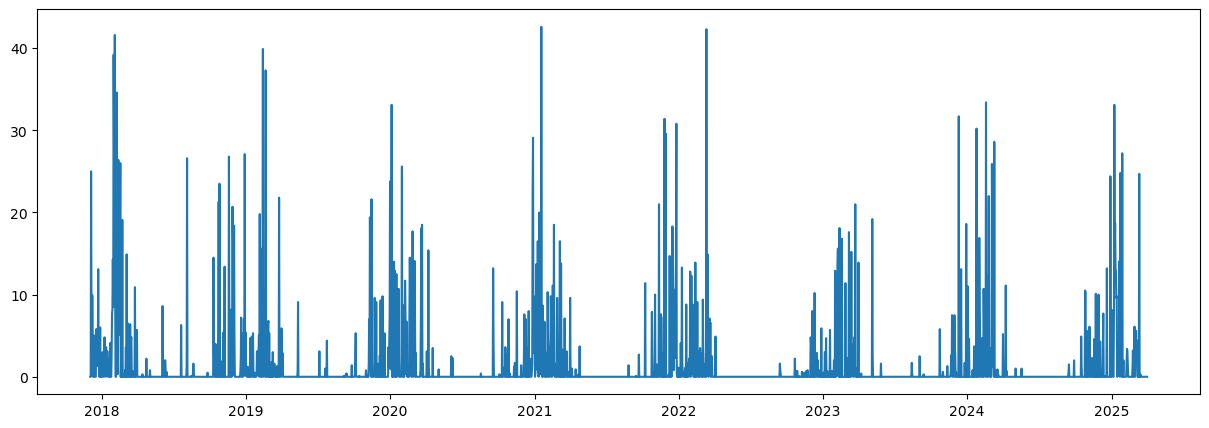

In [4]:
# Observamos el comportamiento de las precipitaciones segun los datos

plt.figure(figsize=(15,5))
plt.plot(df_prec_max)
plt.show()

### Division de datos

In [5]:
#Obtenemos la lista de valores de precipitación

prec_arr = df_prec_max.filter(['Precipitación'])
#Seleccionamos de la lista solo los valores de la precipitación
prec_datos = prec_arr.values
#Definimos el limite o el tamaño de datos que se utilizaran para entrenamiento (70%)
train_prec_tam = int(np.ceil(len(prec_datos) * 0.70))

#Definimos el limite o el tamaño de datos que se utilizaran para la prueba y validación (20% y 10%)
# 0% entrenamiento 70% prueba 90% validacion 100%
val_tam = int(np.ceil(len(prec_datos) * 0.9)) ##

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
#Escalamos los datos con Min-max
sc = MinMaxScaler()
sc_df_prec = sc.fit_transform(prec_datos)

In [8]:
# Seleccionamos hasta el 70% de los datos para el entrenamiento
train_df_prec = sc_df_prec[:train_prec_tam]

In [9]:
X_train, y_train = [], []

# Creamos la dimension 3d de datos para utilizarlo en la red LSTM (window)
for i in range(TIME_STEP, len(train_df_prec)):
    X_train.append(train_df_prec[i-TIME_STEP:i, 0])
    y_train.append(train_df_prec[i,0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
# Formando el Window para el modelo LSTM [datos, pasos, cantidad de variables objetivo]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1867, 7, 1)

### Creando el modelo LSTM

In [11]:
from tensorflow import keras

from keras import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.metrics import RootMeanSquaredError

In [12]:
# Creamos y configuramos el modelo LSTM con sus capas y parametros correspondientes

modelo_lstm = Sequential()

# Capas LSTM que recordaran datos relevantes de la secuencia
modelo_lstm.add(LSTM(10,return_sequences=True, input_shape=(X_train.shape[1], 1)))
modelo_lstm.add(LSTM(10,return_sequences=True))
modelo_lstm.add(LSTM(15,return_sequences=False))

#Tranformamos valores < 0 a el valor de 0
modelo_lstm.add(Dense(64, activation='relu'))

#Capa para evitar un sobreajuste del modelo
modelo_lstm.add(Dropout(0.5))

# Capa de salida (1 por que predecimos una variable)
modelo_lstm.add(Dense(1))

modelo_lstm.summary()

C:\Users\RicardoPC\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 10)               │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 10)               │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 15)                  │           1,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,969 (15.50 KB)

 Trainable params: 3,969 (15.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [14]:
# Compilamos el modelo creado y configurado, utilizamos el error MSE y RMSE
modelo_lstm.compile(optimizer=Adam(),
                    loss='mse',
                    metrics=[RootMeanSquaredError()])

In [15]:
#Creamos un "checkpoint" para que guarde el modelo solo si es mejor que alguno ya existente
model_check = ModelCheckpoint('./Mejores_Modelos/mejor_modelo_prec.keras', monitor='root_mean_squared_error', save_best_only=True)

In [16]:
# Entrenamos el modelo
# training = modelo_lstm.fit(X_train, 
#                            y_train, 
#                            epochs=200,
#                            batch_size=32,
#                            callbacks=[model_check])

In [17]:
# Graficamos el proceso de entrenamiento del modelo 
# plt.plot(training.history['loss'], label='loss')
# plt.legend();
# plt.show()

In [18]:
## Preparando los datos de prueba seleccionando 
test_prec = sc_df_prec[train_prec_tam - TIME_STEP:val_tam]
X_test = []

In [19]:
# Creamos la dimension 3d de datos para utilizarlo en la red LSTM (window)

for i in range(TIME_STEP, len(test_prec)):
    X_test.append(test_prec[i-TIME_STEP:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [20]:
# Cargamos el mejor modelo entrenado

mejor_modelo_lstm = keras.models.load_model('./Mejores_Modelos/mejor_modelo_prec.keras')

In [21]:
# Realizamos una prediccion sobre los datos de prueba

y_pred = mejor_modelo_lstm.predict(X_test)

# Reescalamos los datos a su forma original

y_pred_resc = sc.inverse_transform(y_pred)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [22]:
# Obteniendo los datos de prueba (20%)

test_prec = df_prec_max[train_prec_tam:val_tam]

In [23]:
# Realizamos una copia de los datos de prueba

test_prec_cp = test_prec.copy()

In [24]:
# Agregamos la columna de prediccion con lo valores predichos por el modelo

test_prec_cp['Prediccion'] = y_pred_resc

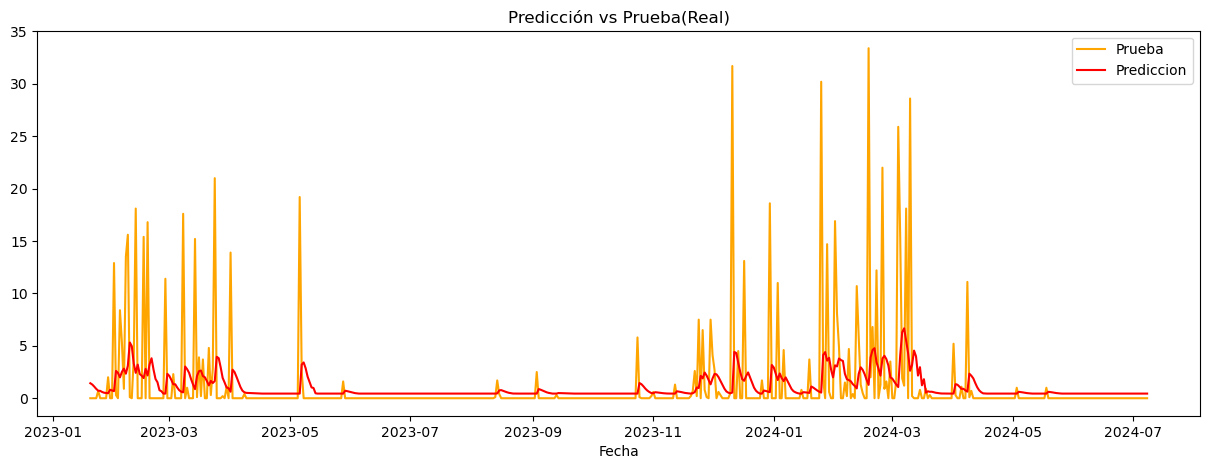

In [25]:
# Graficamos el resultados de las predicciones sobre los datos de prueba

plt.figure(figsize=(15,5))
plt.plot(test_prec_cp['Precipitación'], label="Prueba", color='orange')
plt.plot(test_prec_cp['Prediccion'], label="Prediccion", color='red')
plt.title("Predicción vs Prueba(Real)")
plt.xlabel("Fecha")
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Obtenemos las metricas generadas

print('Resultados de la prueba:')
print('Métrica de MAE:', mean_absolute_error(test_prec_cp['Precipitación'], y_pred_resc).round(4))
print('Métrica de RMSE:', np.sqrt(mean_squared_error(test_prec_cp['Precipitación'], y_pred_resc)).round(4))

Resultados de la prueba:
Métrica de MAE: 1.8216
Métrica de RMSE: 4.2452


In [27]:
## Obtenemos los valores de precipitacion escalados
val_prec = sc_df_prec[val_tam - TIME_STEP:]

In [28]:
X_val = []

In [29]:
# Creamos el window para pasarlos al modelo LSTM

for i in range(TIME_STEP, len(val_prec)):
    X_val.append(val_prec[i-TIME_STEP:i,0])

X_val = np.array(X_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [30]:
y_pred_val = mejor_modelo_lstm.predict(X_val)
y_pred_resc_val = sc.inverse_transform(y_pred_val)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [31]:
# Obtenemos el ultimo 10% de los datos (validación)

val_prec = df_prec_max[val_tam:] #10%
val_prec_cp = val_prec.copy()

In [32]:
val_prec_cp['Prediccion'] = y_pred_resc_val

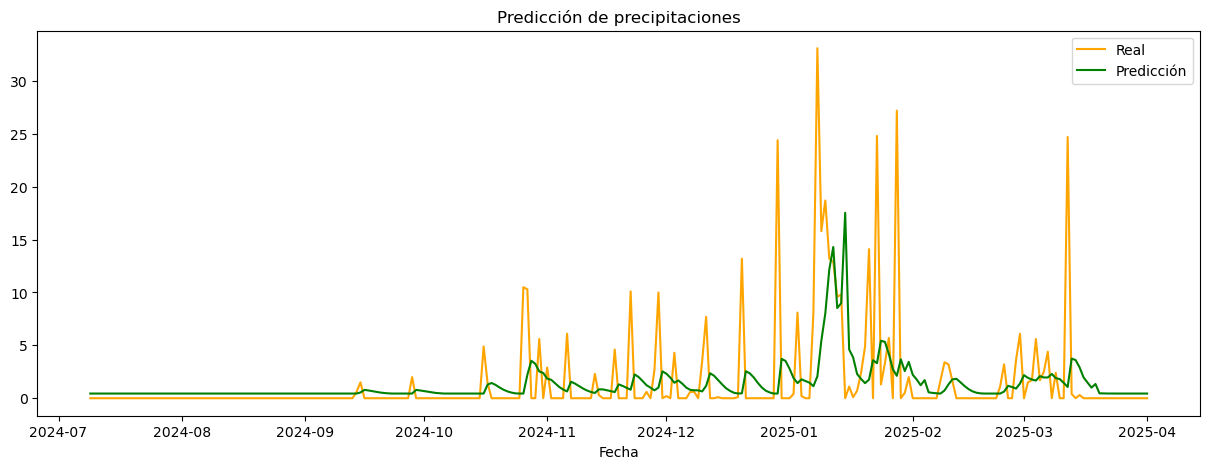

In [33]:
plt.figure(figsize=(15,5))
plt.plot(val_prec_cp['Precipitación'], label="Real", color='orange')
plt.plot(val_prec_cp['Prediccion'], label="Predicción", color='green')
plt.title("Predicción de precipitaciones")
plt.xlabel("Fecha")
plt.legend()
plt.show()

In [34]:
print('Resultado de la validación:')
print('Métrica de MAE:', mean_absolute_error(val_prec_cp['Precipitación'], y_pred_resc_val).round(4))
print('Métrica de RMSE:', np.sqrt(mean_squared_error(val_prec_cp['Precipitación'], y_pred_resc_val)).round(4))

Resultado de la validación:
Métrica de MAE: 1.9558
Métrica de RMSE: 4.3524


In [35]:
## Exportando resultados de predicciones
#val_prec_cp.to_csv('./predicciones de modelos/prediccion_precipitacion_LSTM.csv')